# Class Activation Maps with grad-CAM visualization technique

A deep Convolutional Neural Network has a main drawback related to the difficulty in interpreting its internal processes. When a new unseen data sample is given to the model, it is hard to capture what makes it arrive at a particular classification decision. In association with high accuracy results, understanding the reasons behind predictions is equally quite important in assessing trust in the model.

**Explainability** is defined as the ability to provide qualitative understanding of deep neural networks for which it is possible to explain why they predict what they predict. There is no a well-established standard method to explain a DNN. One of the methods typically used consists in visualizing what the network has learned through specific techniques.
These techniques aim to identify which discriminative pixels in the image influence the final prediction.

In our specific example, we want to verify through an image that the attention of the network is focused on the dense regions of the mammogram to demonstrate that the classification result is given on the bases of the feature we expect. Visualization tools have been applied after training the model without altering its architecture.

We use the *visualize_cam* utility function, provided by Keras, to generate a gradient based class activation map, which is an image indicating the input regions whose change would most contribute towards maximizing the output. This function is based on the **grad-CAM** specific technique.

The Grad-CAM $L^c_{GradCAM}$ is a weighted combination of forward activation maps, followed by a ReLU:

\begin{equation}
L^c_{GradCAM} = ReLU(\sum_{k} \alpha^c_k A^K)
\end{equation}

with

\begin{equation}
\alpha^c_k = \frac{1}{z} \sum_{i} \sum_{j} \frac{\partial y^c}{\partial A^k_{ij}}
\end{equation}

The neuron importance weight $\alpha^c_k$ highlights the ‘importance’ of feature map $k$ for a target class $c$. To obtain these weights, we first compute the gradient of the score for class $c$, $y^c$ , with respect to feature map activations $A^k$ of a convolutional layer, i.e. $\frac{\partial y^c}{\partial A^k}$. Then these gradients flowing back are global-average-pooled over the width and height dimensions (indexed by $i$ and $j$ respectively). During computation of $\alpha^c_k$ while backpropagating gradients with respect to activations, the exact computation is the successive matrix products of the weight matrices and the gradient with respect to activation functions till the final convolution layer that the gradients are being propagated to. Hence, this weight $\alpha^c_k$ highlights the ‘importance’ of feature map k for a target class c. A $ReLU$ function is applied to the linear combination of maps because we are only interested in the features that have a positive influence on the class of interest, i.e. pixels whose intensity should be increased in order to increase $y^c$ .

The places where the gradient is large let us exactly define the region that has a large impact on the final score decision. Thus we obtain a heatmap that indicates which areas of an image are being used by the model for discrimination among classes.

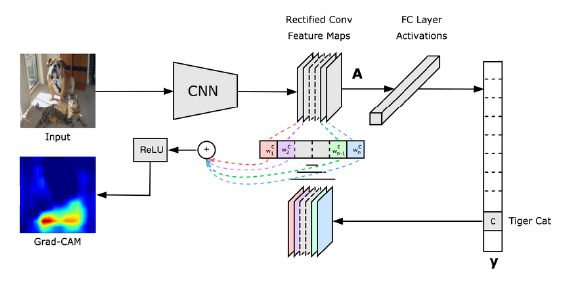

In [15]:
from vis.utils import utils
from keras import activations
from keras import models
from keras.models import load_model, Model
from vis.utils import utils
from matplotlib import pyplot as plt
from keras.preprocessing import image
from vis.visualization import visualize_saliency, overlay, visualize_activation, visualize_cam
import numpy as np
import scipy.misc
import matplotlib
import math
from scipy.ndimage import convolve
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

## Model loading

The first step to generate the activation maps is the selection and the loading of a specific previously trained ResNet model that we want to analyze.
 
We uploaded in the folder a CNN model pre-trained on the CC_R projections that you can use as xample to understand how this code works. But, you can insert the path to your own trained model correspondent to the epoch that produced the best validation accuracy improvement. Obviously you can use models trained on different projections by simply changing the path.

With the *summary()* function, we can clearly see

  - The layers and their order in the model.
  - The output shape of each layer.
  - The number of parameters (weights) in each layer.
  - The total number of parameters (weights) in the model.


In [16]:
path='CC_R_model/'
model=load_model(path + 'weights-improvement-46-0.80.h5')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 650, 650, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 325, 325, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 325, 325, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 325, 325, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

## Layers definition

To compute the Grad-CAM we have to define two layers:

  - **layer_idx**: The layer index within *model.layers* whose filters needs to be visualized. We define it as the one related to the final dense layer, because the weights $\alpha^c_k$ are simply the weights of the final fully connected layers in a network.

  - **penultimate_layer_idx**: The pre-layer to *layer_idx* whose feature maps $A^k_{ij}$ should be used to compute gradients  with reference to filter output. We define it as the last convolutional layer, named *add_12* in the model summary.

Moreover, we swap the final layer’s Softmax activation function with a Linear activation function, which simply passes input $x$ as $x$. As Grad-CAMs are generated by weighing the gradients of the output class prediction with respect to the feature maps of the last convolutional layer of your model, you need to ensure that information passes properly. Softmax breaks this pattern, and hence you need to convert it into Linear. 

In [17]:
layer_idx = utils.find_layer_idx(model, 'dense_1')  #Utility to search for layer index by name.
model.layers[layer_idx].activation = activations.linear   
modelnew = utils.apply_modifications(model)
penultimate_layer = utils.find_layer_idx(modelnew, 'add_12')

## Input sample definition

Input samples to be visualized must be specified; they are the images we want to display the heatmaps on. 

We uploaded some examples of test images in the folder *TestSet*. The images are divided by projection and by class. You can select the projection and the class for wich you want to visualize the map and this script will produce the map for all the images in that folder. We just uploaded one image per class as example. Obviously, you can use the script on your own test set of images.


In [18]:
proj = 'CC_R'
classe = 'B'
path_test='TestSet/'+ proj + '/test/'
patient_ID = [d for d in os.listdir(path_test + classe) if os.path.isfile(os.path.join(path_test + classe, d))]
print(patient_ID)

['1103_1_B_CC_R.png']


## Maps generation

To generate Class Activation Maps, we use the function *visualize_cam*, which is a utility of *keras-vis*, a toolkit that can be integrated with Keras models, and used for visualization. As said, it is based on the Grad-CAM technique.

Another explanation of how it works can be found at: https://fairyonice.github.io/Grad-CAM-with-keras-vis.html

1. The images on which we want to display the heatmaps have to undergo the same preprocessing procedures applied to the images used to train the network, including resize and normalization, so that they are compatible with the model. Therefore, we resize them to 650x650, we create a tensor of 3 channels with the image repeated in 3 dimensions, we normalize the images by setting each input mean to 0 and multiplying the data by a rescaling factor, which is 1./255. We also have to add a new axis as the model input shape must be: (samples, channels, image_dims...) 

2. Let's use the model to predict the class of the image, so that we have the outcome of the neural network and we can know if we are obtaining the map for a correctly classified image.

3. Let's save the reshaped image

4. We finally apply the function *visualize_cam*. It enerates a gradient based class activation map (grad-CAM) that maximizes the outputs of *filter_indices* in *layer_idx*. We have to define the following parameters:
    - **model** : The keras.models.Model instance. In our case it is the pre-trained model in which we swapped the final layer’s Softmax activation function with a Linear activation functio.
    - **layer_idx** : The layer index within model.layers whose filters needs to be visualized. In our case it is the final dense layer.
    - **filter_indices** : filter indices within the layer to be maximized. For keras.layers.Dense layer, filter_idx is interpreted as the output index. So, we define it as the index of the predicted class.
    - **seed_input** : The input image for which activation map needs to be visualized. It is the resized image we have previously defined.
    - **penultimate_layer_idx**: The pre-layer to layer_idx whose feature maps should be used to compute gradients wrt filter output. It has been set to the last convolutional layer *add_12*.

   It returns: The heatmap image indicating the input regions whose change would most contribute towards maximizing the output of filter_indices.
    
Example:
    If you wanted to visualize attention over 'B' category, say output index 1 on the final keras.layers.Dense layer, then, filter_indices = [1], layer = dense_layer.

You can try to use different layers and study how the maps change.

If the predicted label is equal to the true label, you can evaluate the map by observing if the active area in the map matches the dense region in the original mammogram to check if the model is looking at the right feature.

If the predicted label is different from the true label, you can use the map to understand why the model failed.
    
Choose where to save the maps. In this tutorial, we save both the pre-processed images and the maps divided by projection and true class in the folder *'MAPS'*.

1103_1_B_CC_R.png
(1, 650, 650, 3)
The predicted class is B.


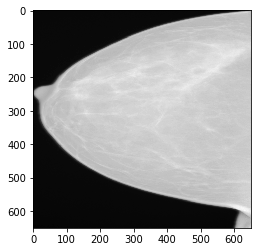

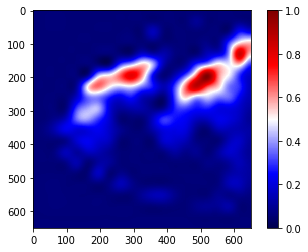

In [39]:
pathtosave = 'MAPS/'+ proj + '/' + classe

for i in patient_ID: 
    print(i)
    indice=i.index('.')
    
    img = utils.load_img(path_test + classe +'/' + i, target_size=(650, 650))
    tensor=[img, img, img]
    img_reshape=np.stack(tensor, axis=2)
    mean = img_reshape.mean()
    img_reshape = (img_reshape - mean)
    img_reshape = (img_reshape)*1./255
    img_resized = img_reshape[np.newaxis, ...]
    print(img_resized.shape)
        
    pred_class = np.argmax(model.predict(img_resized))
    if pred_class==0: class_string = "A"
    if pred_class==1: class_string = "B"
    if pred_class==2: class_string = "C"  
    if pred_class==3: class_string = "D"
    print("The predicted class is %s." % class_string)
    

    scipy.misc.imsave(pathtosave + '/' + class_string + '_'+ i[:indice]+'_650.png', img_reshape)
    
  
    mappa=visualize_cam(modelnew, layer_idx, filter_indices=[pred_class], seed_input=img_resized, penultimate_layer_idx=penultimate_layer)

    plt.imsave(pathtosave + '/' + class_string + '_' + i[:indice] + '_map.png' , mappa, cmap='seismic')
    


    plt.imshow(img, cmap='gray')
    plt.show()
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(mappa, cmap='seismic')
    ax.figure.colorbar(im, ax=ax)
    


## Maps overlay

Let's overaly the map on the original image, by using the function [*cv2.addWeighted*](https://docs.opencv.org/master/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19) provided by the *OpenCV* library, which requires tensors with the same dimension.


B_1103_1_B_CC_R_650.png


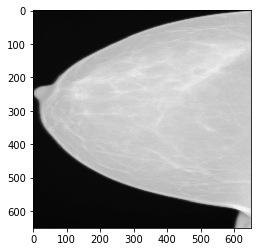

(650, 650, 3)
(650, 650, 4)
B_1103_1_B_CC_R_map.png
(650, 650, 4)


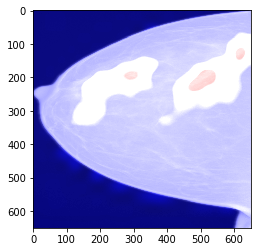

In [42]:
images = [d for d in os.listdir(pathtosave) if os.path.isfile(os.path.join(pathtosave, d))]

for i in images:
    indice=i.index('.')-4
    if i[indice:] == '_650.png':
        print(i)
        immagine=utils.load_img(pathtosave + '/' + i)
        plt.imshow(immagine)
        plt.show()
        print(immagine.shape)
        immagine = cv2.cvtColor(immagine, cv2.COLOR_RGB2RGBA)
        print(immagine.shape)
        
        print(i[:indice] + '_map.png')
        mappa_color=utils.load_img(pathtosave + '/' + i[:indice] + '_map.png')
        print(mappa_color.shape)
        
        mappa_overlay=cv2.addWeighted(immagine, 1, mappa_color, 1, 0)
        plt.imshow(mappa_overlay)
        plt.show()
        scipy.misc.imsave(pathtosave + '/' + i[:indice]+'_overlay.png', mappa_overlay)
        
        
      
    